In [1]:
import os
from dotenv import load_dotenv

load_dotenv()

# 4. API 키들이 잘 로드되었는지 확인합니다.
if not os.getenv("OPENAI_API_KEY") or not os.getenv("PINECONE_API_KEY"):
    print("OPENAI_API_KEY 또는 PINECONE_API_KEY가 .env 파일에 설정되지 않았습니다.")
else:
    print("API 키가 성공적으로 로드되었습니다.")

API 키가 성공적으로 로드되었습니다.


In [2]:
# --- 셀 2: State 정의 및 도구 준비 ---

from typing import List, TypedDict
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain_openai import ChatOpenAI

# 1. 에이전트의 기억 상자(State) 양식을 정의합니다.
class AgentState(TypedDict):
    # --- 입력 데이터 ---
    title: str
    description: str
    # --- 중간 과정 데이터 ---
    query: str
    context: List[Document]
    answer: str
    rewrite_count: int
    decision: str

print("AgentState가 정의되었습니다.")

# 2. LLM 모델을 준비합니다.
llm = ChatOpenAI(model="gpt-4o-mini")
print(f"LLM 모델({llm.model_name})이 준비되었습니다.")

# 3. Pinecone 데이터베이스를 준비합니다.
# .env 파일에 PINECONE_INDEX_NAME="moit-agent-index" 와 같이 설정해주세요.
index_name = os.getenv("PINECONE_INDEX_NAME")
if not index_name:
    print("PINECONE_INDEX_NAME이 .env 파일에 설정되지 않았습니다.")
else:
    embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')
    
    # 임시 테스트용 데이터 (인덱스가 비어있을 경우에만 추가됩니다)
    temp_documents = [
        Document(page_content="[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.", metadata={"location": "강남", "day": "토"}),
        Document(page_content="[홍대] 주말 오후 2시, 다 함께 보드게임 즐길 사람 모여라! 초심자 대환영.", metadata={"location": "홍대", "day": "주말"}),
    ]
    
    # Pinecone 인덱스에 연결하고, 데이터가 없으면 임시 데이터를 추가합니다.
    vector_store = PineconeVectorStore.from_documents(
        documents=temp_documents,
        embedding=embedding_function,
        index_name=index_name
    )
    retriever = vector_store.as_retriever(search_kwargs={'k': 2})
    
    print(f"Pinecone 인덱스 '{index_name}'가 성공적으로 준비되었습니다.")

c:\Users\user\MOIT\MOIT_AGENT\MOIT_graph\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\user\MOIT\MOIT_AGENT\MOIT_graph\Lib\site-packages\langchain_pinecone\__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


AgentState가 정의되었습니다.
LLM 모델(gpt-4o-mini)이 준비되었습니다.
Pinecone 인덱스 'moit-event'가 성공적으로 준비되었습니다.


In [3]:
# --- 셀 3: 모든 노드(행동) 함수 정의 ---

from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser

# --- Node 1: 정보 검색 (retrieve) ---
def retrieve(state: AgentState):
    """DB에서 관련 모임 정보를 검색합니다."""
    print("--- 1. RETRIEVE ---")
    query = state['query']
    context = retriever.invoke(query)
    print("검색된 정보:", [doc.page_content for doc in context])
    return {"context": context}

# --- Node 2: 답변 생성 (generate) ---
generate_prompt = ChatPromptTemplate.from_template(
    """당신은 MOIT 플랫폼의 친절한 모임 추천 AI입니다.
    사용자에게 모임을 추천할 때는 반드시 아래 [검색된 정보]를 기반으로, 어떤 모임인지 명확하게 설명해주세요.

    [검색된 정보]:
    {context}

    [사용자 질문]:
    {query}
    """
)
generate_chain = generate_prompt | llm | StrOutputParser()

def generate(state: AgentState):
    """검색된 정보를 바탕으로 답변을 생성합니다."""
    print("--- 2. GENERATE (LLM 호출) ---")
    query = state['query']
    context_docs = state['context']
    context = "\n\n".join(doc.page_content for doc in context_docs)
    answer = generate_chain.invoke({"context": context, "query": query})
    print("생성된 답변:", answer)
    return {"answer": answer}

# --- Node 3: 유용성 검증 (check_helpfulness) ---
check_helpfulness_prompt = ChatPromptTemplate.from_template(
    """당신은 AI 답변을 평가하는 엄격한 평가관입니다.
    주어진 [AI 답변]이 사용자의 [원본 질문]에 대해 정말로 유용하고 직접적인 답변을 하는지 평가해주세요.
    'helpful' 또는 'unhelpful' 둘 중 하나로만 답변해야 합니다.

    [원본 질문]: {query}
    [AI 답변]: {answer}
    """
)
check_helpfulness_chain = check_helpfulness_prompt | llm | StrOutputParser()

def check_helpfulness(state: AgentState):
    """답변이 사용자에게 도움이 되는지 검증합니다."""
    print("--- 3. CHECK HELPFULNESS (LLM 호출) ---")
    query = state['query']
    answer = state['answer']
    result = check_helpfulness_chain.invoke({"query": query, "answer": answer})
    print("판단 결과:", result)
    if 'helpful' in result.lower():
        print("DECISION: helpful")
        return {"decision": "helpful"}
    else:
        print("DECISION: unhelpful")
        return {"decision": "unhelpful"}

# --- Node 4: 질문 재작성 (rewrite_query) ---
rewrite_query_prompt = ChatPromptTemplate.from_template(
    """당신은 사용자의 질문을 더 좋은 검색 결과가 나올 수 있도록 명확하게 다듬는 프롬프트 엔지니어입니다.
    주어진 [원본 질문]을 바탕으로, 벡터 데이터베이스에서 더 관련성 높은 모임 정보를 찾을 수 있는 새로운 검색 질문을 하나만 만들어주세요.
    결과는 오직 새로운 검색 질문 텍스트만 포함해야 합니다.

    [원본 질문]: {query}
    """
)
rewrite_query_chain = rewrite_query_prompt | llm | StrOutputParser()

def rewrite_query(state: AgentState):
    """검색 결과가 별로일 때, 질문을 더 좋게 다시 작성합니다."""
    print("--- 4. REWRITE QUERY (LLM 호출) ---")
    query = state['query']
    new_query = rewrite_query_chain.invoke({"query": query})
    count = state.get('rewrite_count', 0) + 1
    print("새롭게 작성된 질문:", new_query)
    return {"query": new_query, "rewrite_count": count}

print("모든 노드 함수가 최신 버전으로 정의되었습니다!")

모든 노드 함수가 최신 버전으로 정의되었습니다!


In [4]:
# --- [추가] 새로운 노드: 입력 정보 조합 (prepare_query) ---

prepare_query_prompt = ChatPromptTemplate.from_template(
    """당신은 사용자가 입력한 정보를 바탕으로 유사한 다른 정보를 검색하기 위한 최적의 검색어를 만드는 전문가입니다.
    아래 [모임 정보]를 바탕으로, 벡터 데이터베이스에서 유사한 모임을 찾기 위한 핵심적인 검색 질문을 한 문장으로 만들어주세요.

    [모임 정보]:
    - 제목: {title}
    - 설명: {description}
    """
)
prepare_query_chain = prepare_query_prompt | llm | StrOutputParser()

def prepare_query(state: AgentState):
    """사용자가 입력한 모임 정보를 바탕으로 검색용 쿼리를 생성합니다."""
    print("--- 0. PREPARE QUERY (LLM 호출) ---")
    
    title = state['title']
    description = state['description']
    
    query = prepare_query_chain.invoke({
        "title": title,
        "description": description
    })
    
    print("생성된 검색 쿼리:", query)
    return {"query": query}

In [5]:
# --- 셀 4: 그래프 조립 ---

from langgraph.graph import StateGraph, END

# 1. 그래프 빌더를 생성합니다.
graph_builder = StateGraph(AgentState)

# 2. 노드들을 그래프에 등록합니다.
graph_builder.add_node("prepare_query", prepare_query) # <-- 추가
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)
graph_builder.add_node("check_helpfulness", check_helpfulness)
graph_builder.add_node("rewrite_query", rewrite_query)

# 3. 작업 흐름(엣지)을 연결합니다.
graph_builder.set_entry_point("prepare_query")      # <-- 시작점을 'prepare_query'로 변경
graph_builder.add_edge("prepare_query", "retrieve") # <-- 'prepare_query' 다음에 'retrieve' 실행
graph_builder.add_edge("retrieve", "generate")
graph_builder.add_edge("generate", "check_helpfulness")
graph_builder.add_conditional_edges(
    "check_helpfulness",
    lambda state: state['decision'],
    {
        "helpful": END,
        "unhelpful": "rewrite_query"
    }
)
graph_builder.add_edge("rewrite_query", "retrieve")

# 4. 최종 에이전트를 완성(컴파일)합니다.
meeting_agent = graph_builder.compile()

print("그래프가 성공적으로 완성되었습니다!")

그래프가 성공적으로 완성되었습니다!


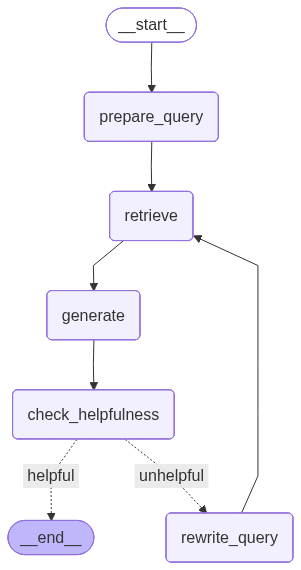

In [7]:
# --- 셀 5: 에이전트 실행 및 시각화 ---
from IPython.display import Image, display

# 1. 그래프 시각화
try:
    img_data = meeting_agent.get_graph().draw_mermaid_png()
    display(Image(img_data))
except Exception as e:
    print(f"그래프 시각화 오류: {e}")

In [8]:
# 2. 에이전트 실행
initial_state = {
    "title": "토요일 저녁에 코딩 공부하실 분!",
    "description": "강남역 근처 카페에서 파이썬 기초 스터디 하려고 합니다. 초보자 환영!",
    "rewrite_count": 0
}

print("\n--- 에이전트 실행 시작 ---")
for event in meeting_agent.stream(initial_state):
    node_name = list(event.keys())[0]
    node_output = event[node_name]
    
    print(f"--- Event: '{node_name}' 노드 실행 ---")
    print(node_output)
    print("\n" + "="*30 + "\n")


--- 에이전트 실행 시작 ---
--- 0. PREPARE QUERY (LLM 호출) ---
생성된 검색 쿼리: "강남역 근처 카페에서 파이썬 기초 공부를 함께 할 초보자 중심의 스터디 모임을 찾고 있습니다."
--- Event: 'prepare_query' 노드 실행 ---
{'query': '"강남역 근처 카페에서 파이썬 기초 공부를 함께 할 초보자 중심의 스터디 모임을 찾고 있습니다."'}


--- 1. RETRIEVE ---
검색된 정보: ['[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.', '[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.']
--- Event: 'retrieve' 노드 실행 ---
{'context': [Document(id='f0f5d857-ee82-4e6a-90cf-baef2ff46af3', metadata={'day': '토', 'location': '강남'}, page_content='[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.'), Document(id='2accc0c9-f269-424f-9b94-b16b44afe34f', metadata={'day': '토', 'location': '강남'}, page_content='[강남] 매주 토요일 저녁 7시, 초보자를 위한 코딩 스터디 모임입니다. 파이썬 기초부터 함께 공부해요.')]}


--- 2. GENERATE (LLM 호출) ---
생성된 답변: 강남역 근처에서 초보자 중심의 파이썬 기초 공부를 함께 할 수 있는 모임을 추천드립니다. 매주 토요일 저녁 7시에 진행되는 코딩 스터디 모임으로, 초보자를 위해 설계된 프로그램입니다. 파이썬의 기초를 함께 학습하며, 서로 지원하고 교류하는 좋은 기회가 될 것입니다. 관심 있으시면 참여해 보세요!
--- Event: 'generate' 노드 실행 ---